<h1 style="text-align:center">Regression for Crowdfunding Data</span>

## Assignment Notice
Build a regression model with crowdfunding data. Your assignment should include the points below.

- Set a problem based on your understanding of crowdfunding data and Kickstarter context.
- It means you select the target variable and input features in the data for your model.
- Use linear regression, Ridge, and Lasso, and compare their performance.
- Select the best-performing model and explain your choice.
- Important Note: Do not just provide the codes. You must discuss your idea and analysis results.
***

## 1. Preparing & Refining Data

In [127]:
import matplotlib.pyplot        as plt
import numpy                    as np
import pandas                   as pd
import seaborn                  as sns
from sklearn.linear_model       import LinearRegression
from sklearn.linear_model       import Lasso
from sklearn.linear_model       import Ridge
from sklearn.model_selection    import train_test_split
from sklearn.preprocessing      import RobustScaler

In [128]:
df_origin = pd.read_excel('../data/crowdfunding_ex.xlsx')

In [129]:
df = df_origin.copy()
def reset_df():
    global df
    df = df_origin.copy()

**Modifying column name & setting 'Project ID' as index**

In [130]:
df.rename(columns={'보상수': '#ofReward', 'Project ID': 'ID', 'Fiends': 'Friends'}, inplace=True)
df.set_index('ID', inplace=True)

pd.set_option('display.max_columns', None) # 모든 column을 표시하도록 설정
df.head(1)

,Title,Backers,Funded,FundedRate,Success,Country,CountryCode,ShortDescription,VideoCount,ImageCount,Tag,TagCode,Goal,Period,StartDate,EndDate,Location,LocationCode,SNS,Friends,#ofCreation,#ofSuccess,#ofInvest,#ofInvestSuccess,#ofReward,#ofCommenters,#ofComments,Total_Updates,Updates_Likes,Updates_Comments
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
prjt1,Give Ear Gospel Songs by Michael hathaway — Ki...,0,0.0,0.0,NaN,"Nashville, TN",1,In order to finish my album I need 4800.00 to ...,0,0,Faith,13,4800.0,19,"Mon, 16 Nov 2015","Sun, 06 Dec 2015","Camden, TN",1,1,26,1,0,0,0,1,0,0,0,0,0


**Q1. 왜 Success가 NaN으로 표기되는가?**

원본 xlsx를 보면 Success가 정수형 값으로 저장되는 게 아닌, \
$=IF(FundedRate>=100,1,2)$의 수식으로 설정되어 있음.\

즉, FundedRate가 100 이상이면 2(Success), 아니라면 1(Failed) 값을 가짐.\
FundedRate로 추론 가능한 값이므로 이 column은 삭제함.

***

**Q2. 불필요한 Column이 있는가?**

자세한 내용은 코드와 함께 기술함.

In [131]:
print('Total Rows:', df.shape[0])
print('Total Columns:', df.shape[1])

TOTAL_ROWS = 767
TOTAL_COLS = 30

Total Rows: 767
Total Columns: 30


In [117]:
display(df[['Country', 'CountryCode']][:5])
print('Countries Count:', len(df.Country.unique()))
print('Country Codes Count:', len(df.CountryCode.unique()))

,Country,CountryCode
ID,,
prjt1,"Nashville, TN",1
prjt2,"Marsing, ID",1
prjt3,"Deutsch, Germany",6
prjt4,"Oslo, Norway",9
prjt5,"San Diego, CA",1


Countries Count: 404
Country Codes Count: 14


Country는 실제 나라가 아님. prjt1의 **Nashville, TN**을 보면, 미국의 경우 'US'가 아닌 도시와 주(state)를 사용하고 있는 걸 볼 수 있음. 따라서 삭제함. 대신 CountryCode (범주형) column을 사용함.

In [118]:
display(df[['Tag', 'TagCode']][:5])
print('Tags Count:', len(df.Tag.unique()))
print('Tag Codes Count:', len(df.TagCode.unique()))

,Tag,TagCode
ID,,
prjt1,Faith,13
prjt2,Publishing,13
prjt3,3D Printing,1
prjt4,Music,11
prjt5,Product Design,5


Tags Count: 130
Tag Codes Count: 15


마찬가지로, 여기서도 Tag를 포괄하는 TagCode를 사용한다.

In [119]:
display(df[['Location', 'LocationCode']][:5])
print('Locations Count:', len(df.Location.unique()))
print('Location Codes Count:', len(df.LocationCode.unique()))

,Location,LocationCode
ID,,
prjt1,"Camden, TN",1
prjt2,"Marsing, ID",1
prjt3,"Lohmar, Germany",6
prjt4,"Strømmen, Norway",9
prjt5,"San Diego, CA",1


Locations Count: 452
Location Codes Count: 15


In [132]:
df_diff = pd.DataFrame(df['CountryCode'].sub(df['LocationCode'], axis=0))
df_unmatch = df[df_diff[0] != 0]
print('Total unmatched:', df_unmatch.shape[0])
df_unmatch[['Country', 'Location', 'CountryCode', 'LocationCode']].head(5)

Total unmatched: 21


,Country,Location,CountryCode,LocationCode
ID,,,,
prjt31,"Auckland, NZ","Ogden, UT",10,1
prjt35,"New York, NY","London, UK",1,3
prjt52,"Seoul, South Korea","Montgomery, AL",14,1
prjt109,"London, UK","Palma de Mallorca, Spain",3,5
prjt166,"Albuquerque, NM","London, UK",1,3


일반적으로는 Country(Code)와 Location(Code)가 같으나, Country와 Location이 다른 경우가 있음. (총 21개) 큰 문제는 없어보여 일단 무시하고 진행.

In [121]:
print('StartDays:', len(df.StartDate.unique()))
print('EndDates:', len(df.EndDate.unique()))

StartDays: 4
EndDates: 49


- Descriptions (Title, ShortDescription) => NLP를 할 것이 아니므로 삭제.
- Categorical
  - ~~Country,~~ CountryCode => CountryCode만 사용
  - ~~Tag,~~ TagCode => TagCode만 사용
  - ~~Location,~~ LocationCode => LocationCode만 사용
- 대체 가능한 값
    - ~~Success~~ = **FundedRate** >= 100 ? 1 : 2
    - ~~FundedRate~~ = **Funded** / **Goal**
    - ~~EndDate~~ - ~~StartDate~~ = Period (구체적인 날짜보다 기간이 더 중요하다고 보임.)

In [133]:
# String column 삭제
df.drop(columns=['Title', 'ShortDescription'], inplace=True)

# 국가, 태그, 지역 삭제 (코드만 남김)
df.drop(columns=['Country', 'Tag', 'Location'], inplace=True)

# 기타 불필요한 값 삭제
df.drop(columns=['Success', 'FundedRate', 'StartDate', 'EndDate'], inplace=True)

In [123]:
df.head(2)

,Backers,Funded,CountryCode,VideoCount,ImageCount,TagCode,Goal,Period,LocationCode,SNS,Friends,#ofCreation,#ofSuccess,#ofInvest,#ofInvestSuccess,#ofReward,#ofCommenters,#ofComments,Total_Updates,Updates_Likes,Updates_Comments
ID,,,,,,,,,,,,,,,,,,,,,
prjt1,0,0.0,1,0,0,13,4800.0,19,1,1,26,1,0,0,0,1,0,0,0,0,0
prjt2,4,1140.0,1,0,0,13,10000.0,30,1,1,2873,11,0,0,0,9,0,0,0,0,0


***

**Q3. 이상치 검사가 필요한 column은 무엇인가?**

- Backers: 75% 구간, 평균에 비해 max값이 지나치게 큼. (Boxplot)
- Friends: 마찬가지로 max 값이 지나치게 크고, 50%까지 0인 게 수상함. (plot)
- #ofCreation, #ofSuccess, #ofInvest, #ofInvestSuccess: 마찬가지로 max만 큼
- #ofReward: 위 값들보단 덜하지만 max가 꽤 큼.
- #ofCommenters, #ofComments, Total_Updates, Updates_Likes, Updates_Comments

In [124]:
df.describe()

,Backers,Funded,CountryCode,VideoCount,ImageCount,TagCode,Goal,Period,LocationCode,SNS,Friends,#ofCreation,#ofSuccess,#ofInvest,#ofInvestSuccess,#ofReward,#ofCommenters,#ofComments,Total_Updates,Updates_Likes,Updates_Comments
count,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,7.670000e+02,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000,767.000000
mean,102.126467,9520.107132,2.370274,0.298566,7.451108,7.659713,2.331581e+05,33.535854,2.387223,0.500652,419.159061,2.289439,0.242503,0.568449,1.868318,7.469361,1.920469,5.165580,2.286832,6.707953,1.474576
std,356.999621,44730.985067,2.745241,1.092718,11.033767,4.000030,5.490664e+06,11.796953,2.786576,0.500326,829.044874,3.281753,1.036472,2.023413,4.986627,6.207995,12.506299,30.336666,3.715555,24.066720,8.282484
min,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2.930000,1.000000,0.000000,0.000000,5.000000,2.000000e+03,29.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,455.000000,1.000000,0.000000,2.000000,7.000000,8.300000e+03,30.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,59.000000,4503.500000,3.000000,0.000000,11.000000,11.000000,2.265442e+04,37.000000,3.000000,1.000000,541.500000,1.000000,0.000000,0.000000,1.000000,10.000000,0.000000,1.000000,3.000000,3.000000,0.000000
max,5829.000000,949925.340000,15.000000,12.000000,85.000000,15.000000,1.520589e+08,60.000000,15.000000,1.000000,5000.000000,20.000000,10.000000,29.000000,31.000000,56.000000,298.000000,702.000000,35.000000,332.000000,159.000000


In [125]:
df.drop(columns=['CountryCode', 'TagCode', 'LocationCode']).corr()

,Backers,Funded,VideoCount,ImageCount,Goal,Period,SNS,Friends,#ofCreation,#ofSuccess,#ofInvest,#ofInvestSuccess,#ofReward,#ofCommenters,#ofComments,Total_Updates,Updates_Likes,Updates_Comments
Backers,1.000000,0.847777,0.177035,0.324433,-0.010038,0.038352,0.011164,0.046065,0.065483,0.157875,0.165991,0.237539,0.260429,0.708382,0.773449,0.400950,0.766103,0.704072
Funded,0.847777,1.000000,0.186028,0.313781,-0.006980,0.037216,0.034930,0.047947,0.021508,0.029464,0.144169,0.167368,0.149149,0.852977,0.845187,0.317528,0.617298,0.644948
VideoCount,0.177035,0.186028,1.000000,0.166823,-0.010707,0.001245,-0.023041,-0.025248,0.020648,0.032813,0.048313,0.049152,0.094014,0.216775,0.197424,0.140294,0.115957,0.148764
ImageCount,0.324433,0.313781,0.166823,1.000000,-0.024878,0.003707,0.020520,-0.027067,0.121241,0.161538,0.182691,0.237970,0.437526,0.283813,0.253820,0.387530,0.286714,0.226832
Goal,-0.010038,-0.006980,-0.010707,-0.024878,1.000000,-0.061171,-0.036188,-0.018828,-0.003307,-0.009569,-0.010789,-0.014367,-0.037703,-0.005532,-0.006087,-0.023607,-0.010170,-0.006688
Period,0.038352,0.037216,0.001245,0.003707,-0.061171,1.000000,0.036325,0.019408,0.001451,-0.053456,-0.044389,-0.059094,-0.008876,0.011359,-0.001988,0.017427,-0.001260,-0.030865
SNS,0.011164,0.034930,-0.023041,0.020520,-0.036188,0.036325,1.000000,0.505263,0.127098,0.110462,0.064110,0.182911,0.027642,0.022437,0.025667,0.065209,-0.000852,-0.007951
Friends,0.046065,0.047947,-0.025248,-0.027067,-0.018828,0.019408,0.505263,1.000000,0.119029,0.071675,0.050273,0.085620,0.032059,0.027739,0.020577,0.088833,0.022481,0.008805
#ofCreation,0.065483,0.021508,0.020648,0.121241,-0.003307,0.001451,0.127098,0.119029,1.000000,0.485189,0.265960,0.214928,0.111933,0.059629,0.068610,0.110631,0.066874,0.084562
#ofSuccess,0.157875,0.029464,0.032813,0.161538,-0.009569,-0.053456,0.110462,0.071675,0.485189,1.000000,0.426570,0.443410,0.219872,0.088808,0.169115,0.208361,0.213389,0.283119


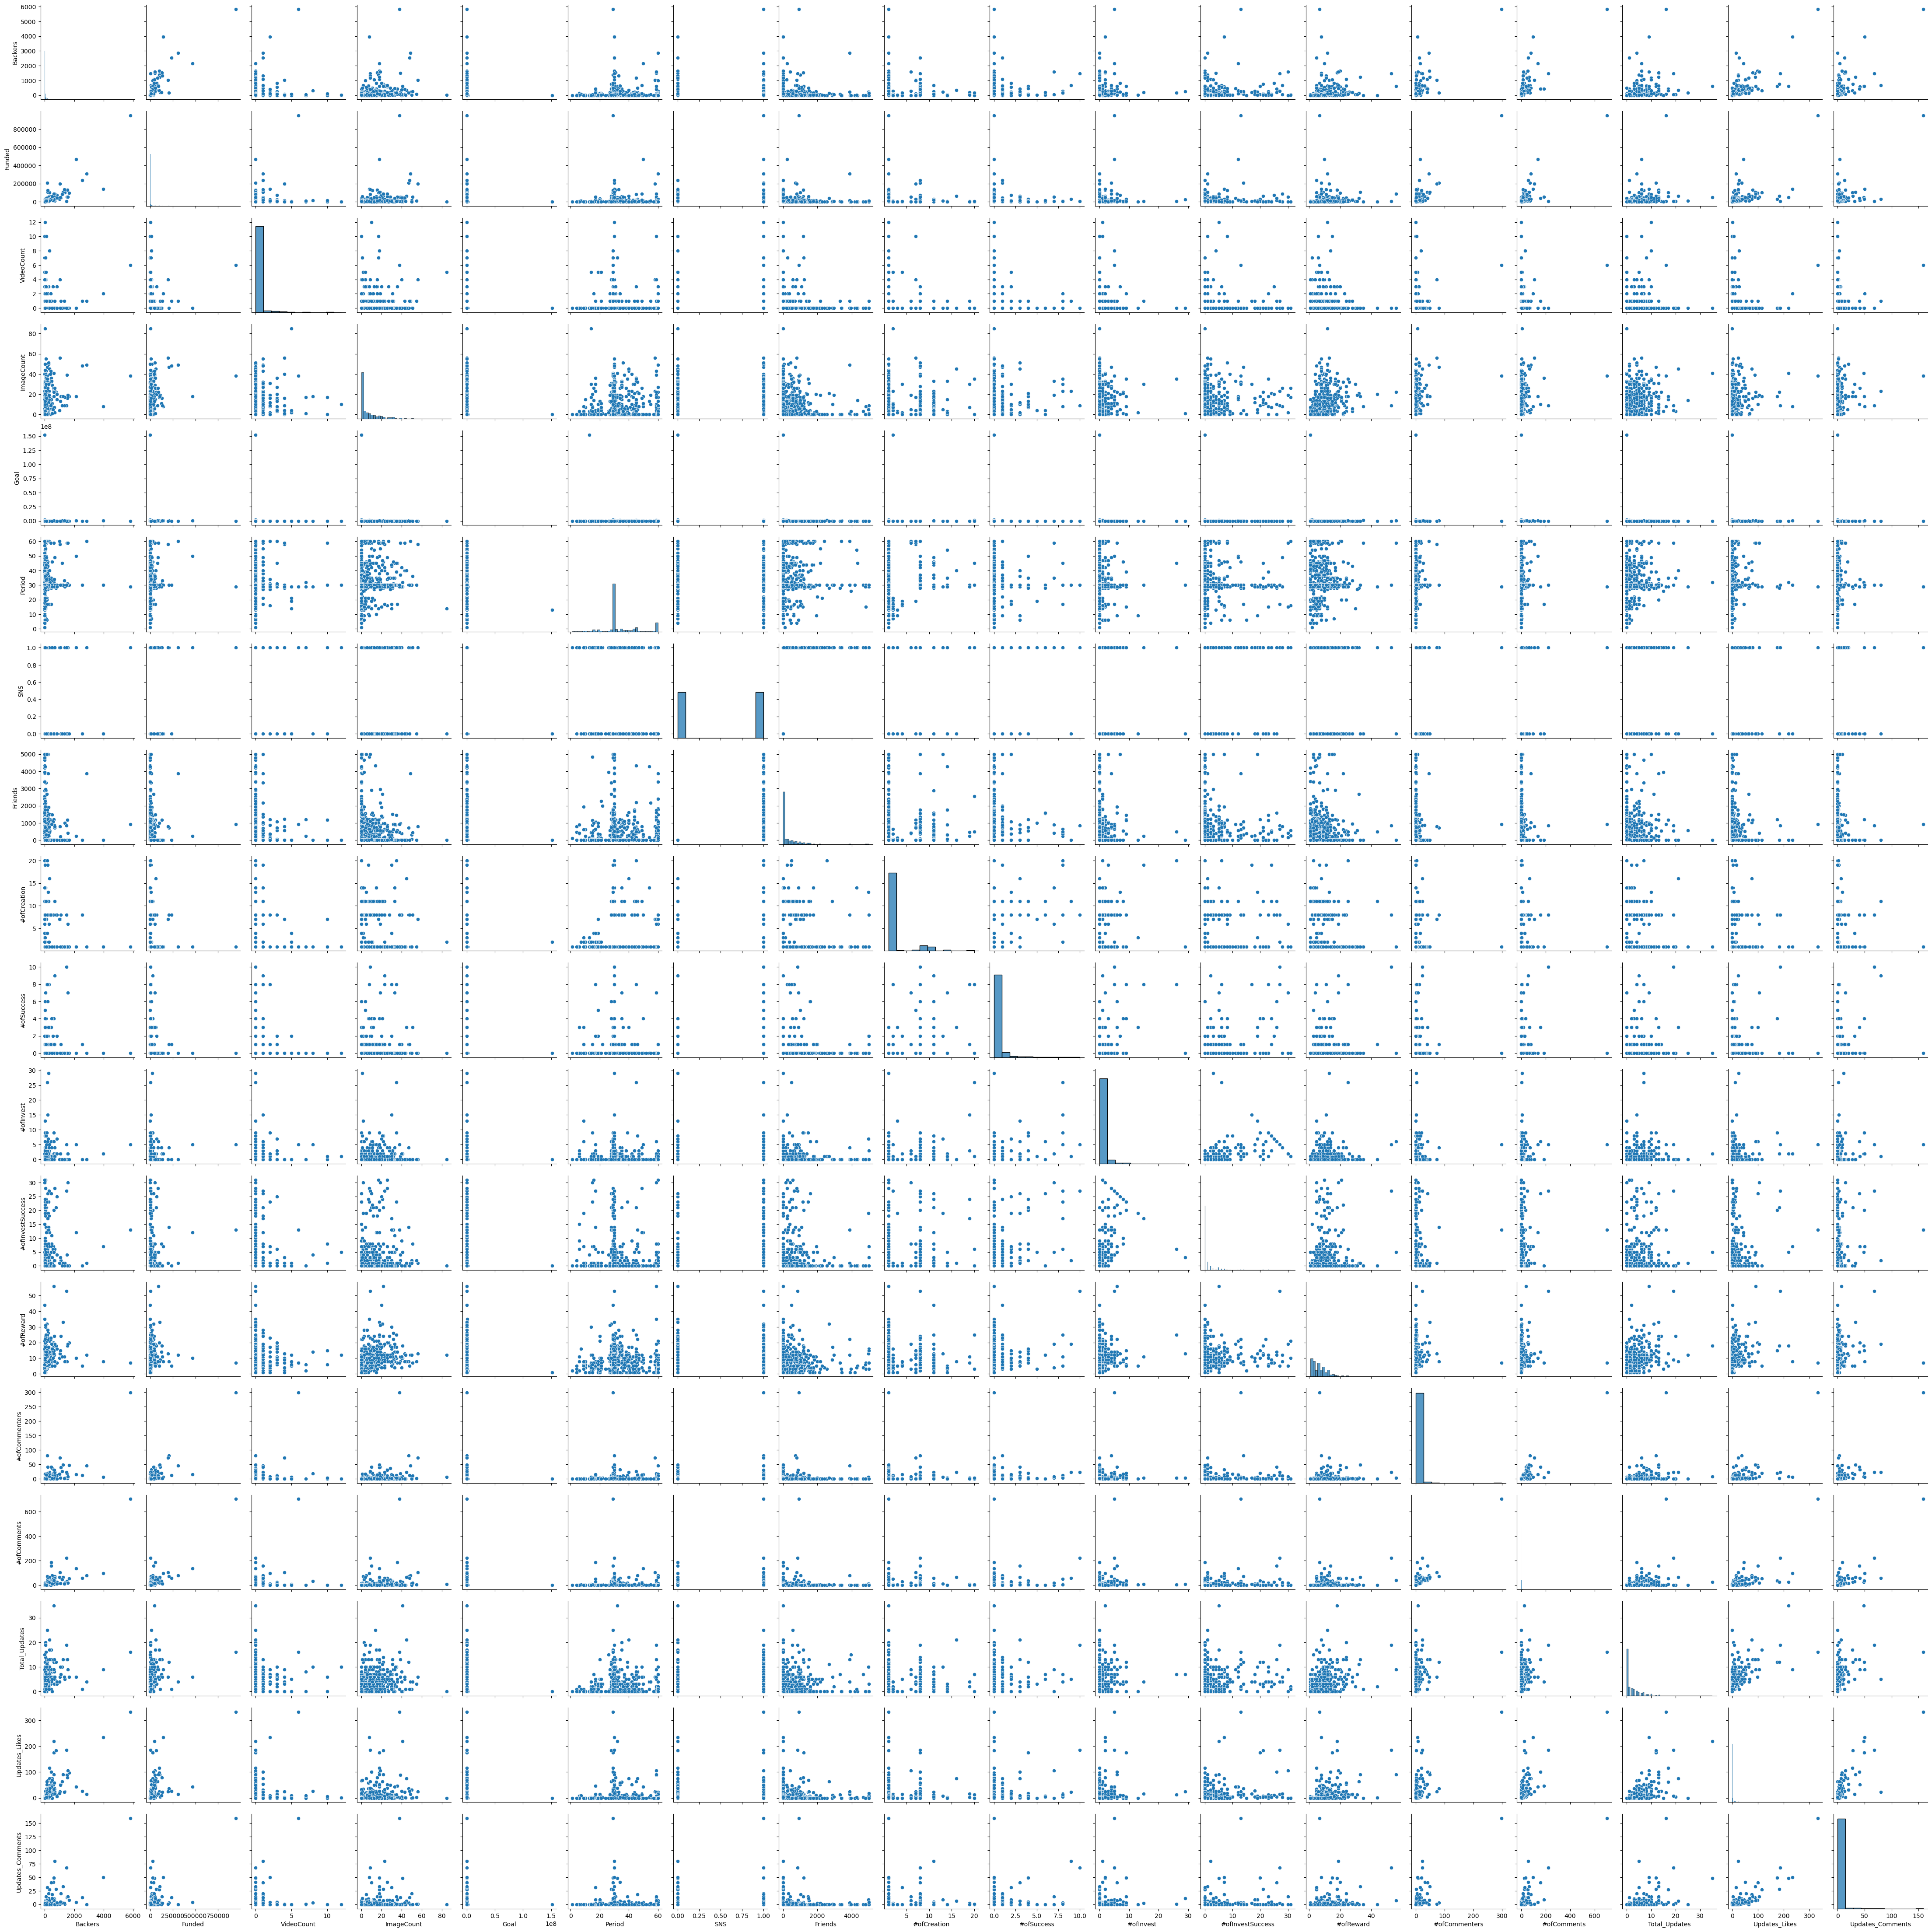

In [134]:
sns.pairplot(df.drop(columns=['CountryCode', 'TagCode', 'LocationCode']))

위 그래프에서, 군집과 멀리 떨어진 점이 찍혀있는 모습을 종종 확인할 수 있다.

**Q4. 추가로 제거해야 할 column이 있는가?**

Friends. SNS를 제외한 대부분의 column과 상관관계를 보이지 않을 뿐더러,\
친구 수가 0인 사람이 극단적으로 많고 5000인 사람도 꽤 된다.\
분석에 도움이 될 것 같지 않으므로 해당 column을 제거한다.\
SNS도 마찬가지로 제거한다.

<Axes: >

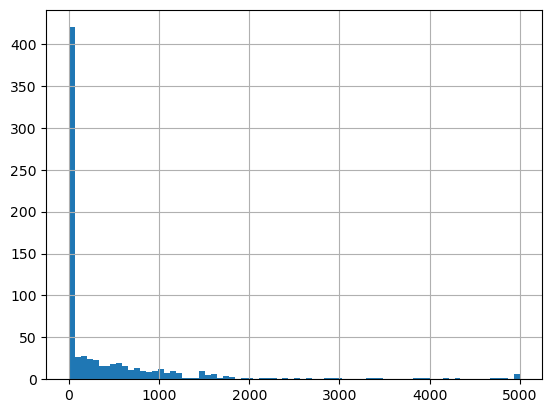

In [ ]:
df['Friends'].hist(bins=TOTAL_ROWS // 10)

In [135]:
df.drop(columns=['Friends', 'SNS'], inplace=True)

,Backers,Funded,Goal,#ofCreation,#ofSuccess,#ofInvest,#ofInvestSuccess,#ofReward,#ofCommenters,#ofComments,Total_Updates,Updates_Likes,Updates_Comments
count,767.000,767.000,767.000,767.000,767.000,767.000,767.000,767.000,767.000,767.000,767.000,767.000,767.000
mean,102.126,9520.107,233158.097,2.289,0.243,0.568,1.868,7.469,1.920,5.166,2.287,6.708,1.475
std,357.000,44730.985,5490663.659,3.282,1.036,2.023,4.987,6.208,12.506,30.337,3.716,24.067,8.282
min,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,2.930,2000.000,1.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000
50%,10.000,455.000,8300.000,1.000,0.000,0.000,0.000,6.000,0.000,0.000,0.000,0.000,0.000
75%,59.000,4503.500,22654.415,1.000,0.000,0.000,1.000,10.000,0.000,1.000,3.000,3.000,0.000
max,5829.000,949925.340,152058877.200,20.000,10.000,29.000,31.000,56.000,298.000,702.000,35.000,332.000,159.000


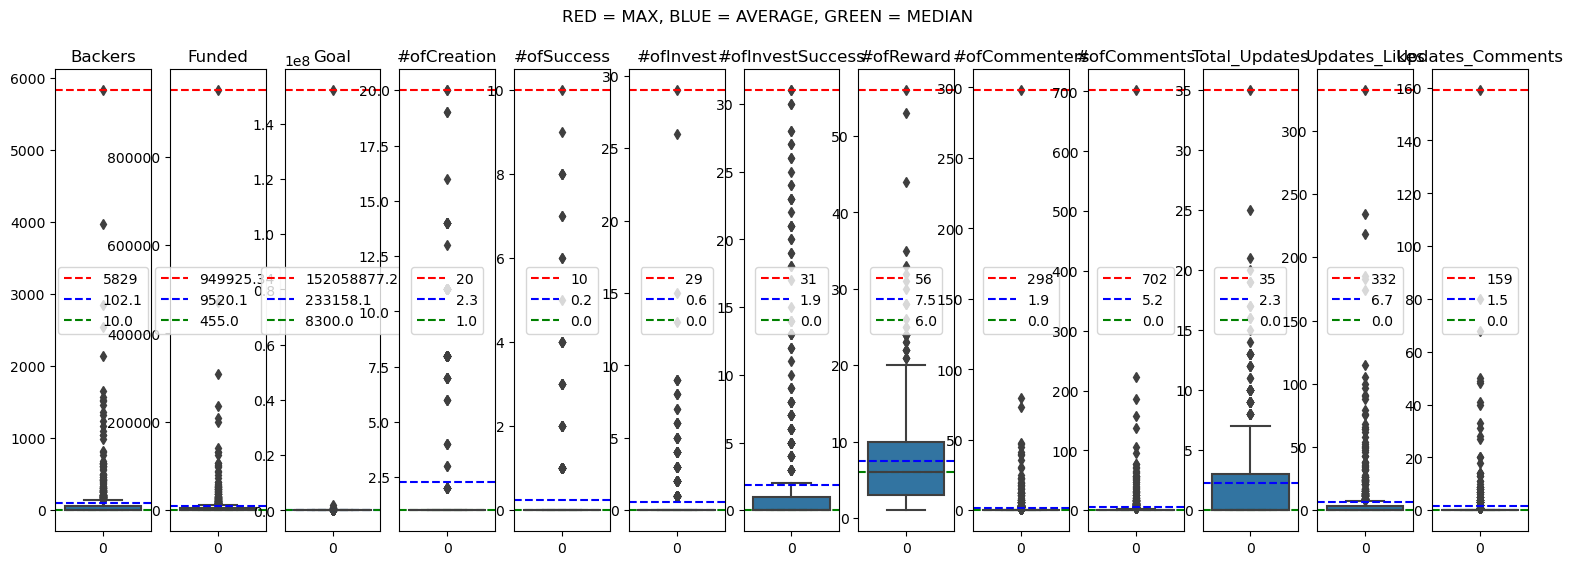

In [ ]:
col_list = ['Backers', 'Funded', 'Goal',
    '#ofCreation', '#ofSuccess', '#ofInvest', '#ofInvestSuccess',
    '#ofReward', '#ofCommenters', '#ofComments', 'Total_Updates',
    'Updates_Likes', 'Updates_Comments']

fig, axes = plt.subplots(1, len(col_list), figsize=(19,6))
display(pd.DataFrame(df[col_list].describe().apply(lambda s: s.apply('{0:.3f}'.format))))

for i in range(len(col_list)):
    sns.boxplot(data=df[col_list[i]], ax=axes[i])
    axes[i].axhline(y=df[col_list[i]].max(), color='r', linestyle='--', label=df[col_list[i]].max())
    axes[i].axhline(y=df[col_list[i]].mean(), color='b', linestyle='--', label=f'{df[col_list[i]].mean():.1f}')
    axes[i].axhline(y=df[col_list[i]].median(), color='g', linestyle='--', label=f'{df[col_list[i]].median():.1f}')
    axes[i].set_title(col_list[i])
    axes[i].legend(loc='center')
fig.suptitle('RED = MAX, BLUE = AVERAGE, GREEN = MEDIAN')
plt.show()

이상치 값들을 삭제한다. average와 mean이 벌어진 정도를 참고하여, max와 가까운 일정 sample을 삭제한다.

In [136]:
df_outlier = df[(df['Backers'] >= 2000)     |
    (df['Funded'] >= 300_000)               |
    (df['Goal'] >= 0.8e6)                   |
    (df['#ofCommenters'] >= 70)             |
    (df['#ofComments'] >= 120)              |
    (df['Total_Updates'] == 21)             |
    (df['Updates_Likes'] >= 150)            |
    (df['Updates_Comments'] == 49)]
display(df_outlier)
print(len(df_outlier))

,Backers,Funded,CountryCode,VideoCount,ImageCount,TagCode,Goal,Period,LocationCode,#ofCreation,#ofSuccess,#ofInvest,#ofInvestSuccess,#ofReward,#ofCommenters,#ofComments,Total_Updates,Updates_Likes,Updates_Comments
ID,,,,,,,,,,,,,,,,,,,
prjt18,2140,469984.00,1,0,18,14,2.500000e+05,50,1,1,0,5,12,10,15,137,6,43,4
prjt29,169,208470.00,9,0,47,5,1.000000e+05,30,9,8,1,4,14,8,80,71,12,36,3
prjt61,605,48002.00,1,0,41,2,2.500000e+04,32,1,1,0,2,5,18,7,25,35,218,48
prjt68,620,27722.00,1,0,18,2,4.000000e+03,29,1,8,4,9,20,15,19,36,12,174,49
prjt144,1041,198824.00,1,4,56,14,3.000000e+04,58,1,7,0,0,1,13,73,105,6,24,1
prjt178,763,64595.00,1,0,22,2,6.000000e+04,28,1,1,0,2,21,18,1,25,12,183,28
prjt188,2,115.00,1,0,8,7,1.250000e+06,59,1,1,0,0,0,35,0,0,1,0,0
prjt211,434,54142.00,1,0,36,9,3.000000e+04,17,1,1,0,0,0,7,4,186,4,46,9
prjt237,0,0.00,1,0,0,7,1.000000e+06,30,1,20,0,1,0,3,0,0,0,0,0


21


In [137]:
print(df.shape[0])
df.drop(index=df_outlier.index, inplace=True)
print(df.shape[0])

767
746


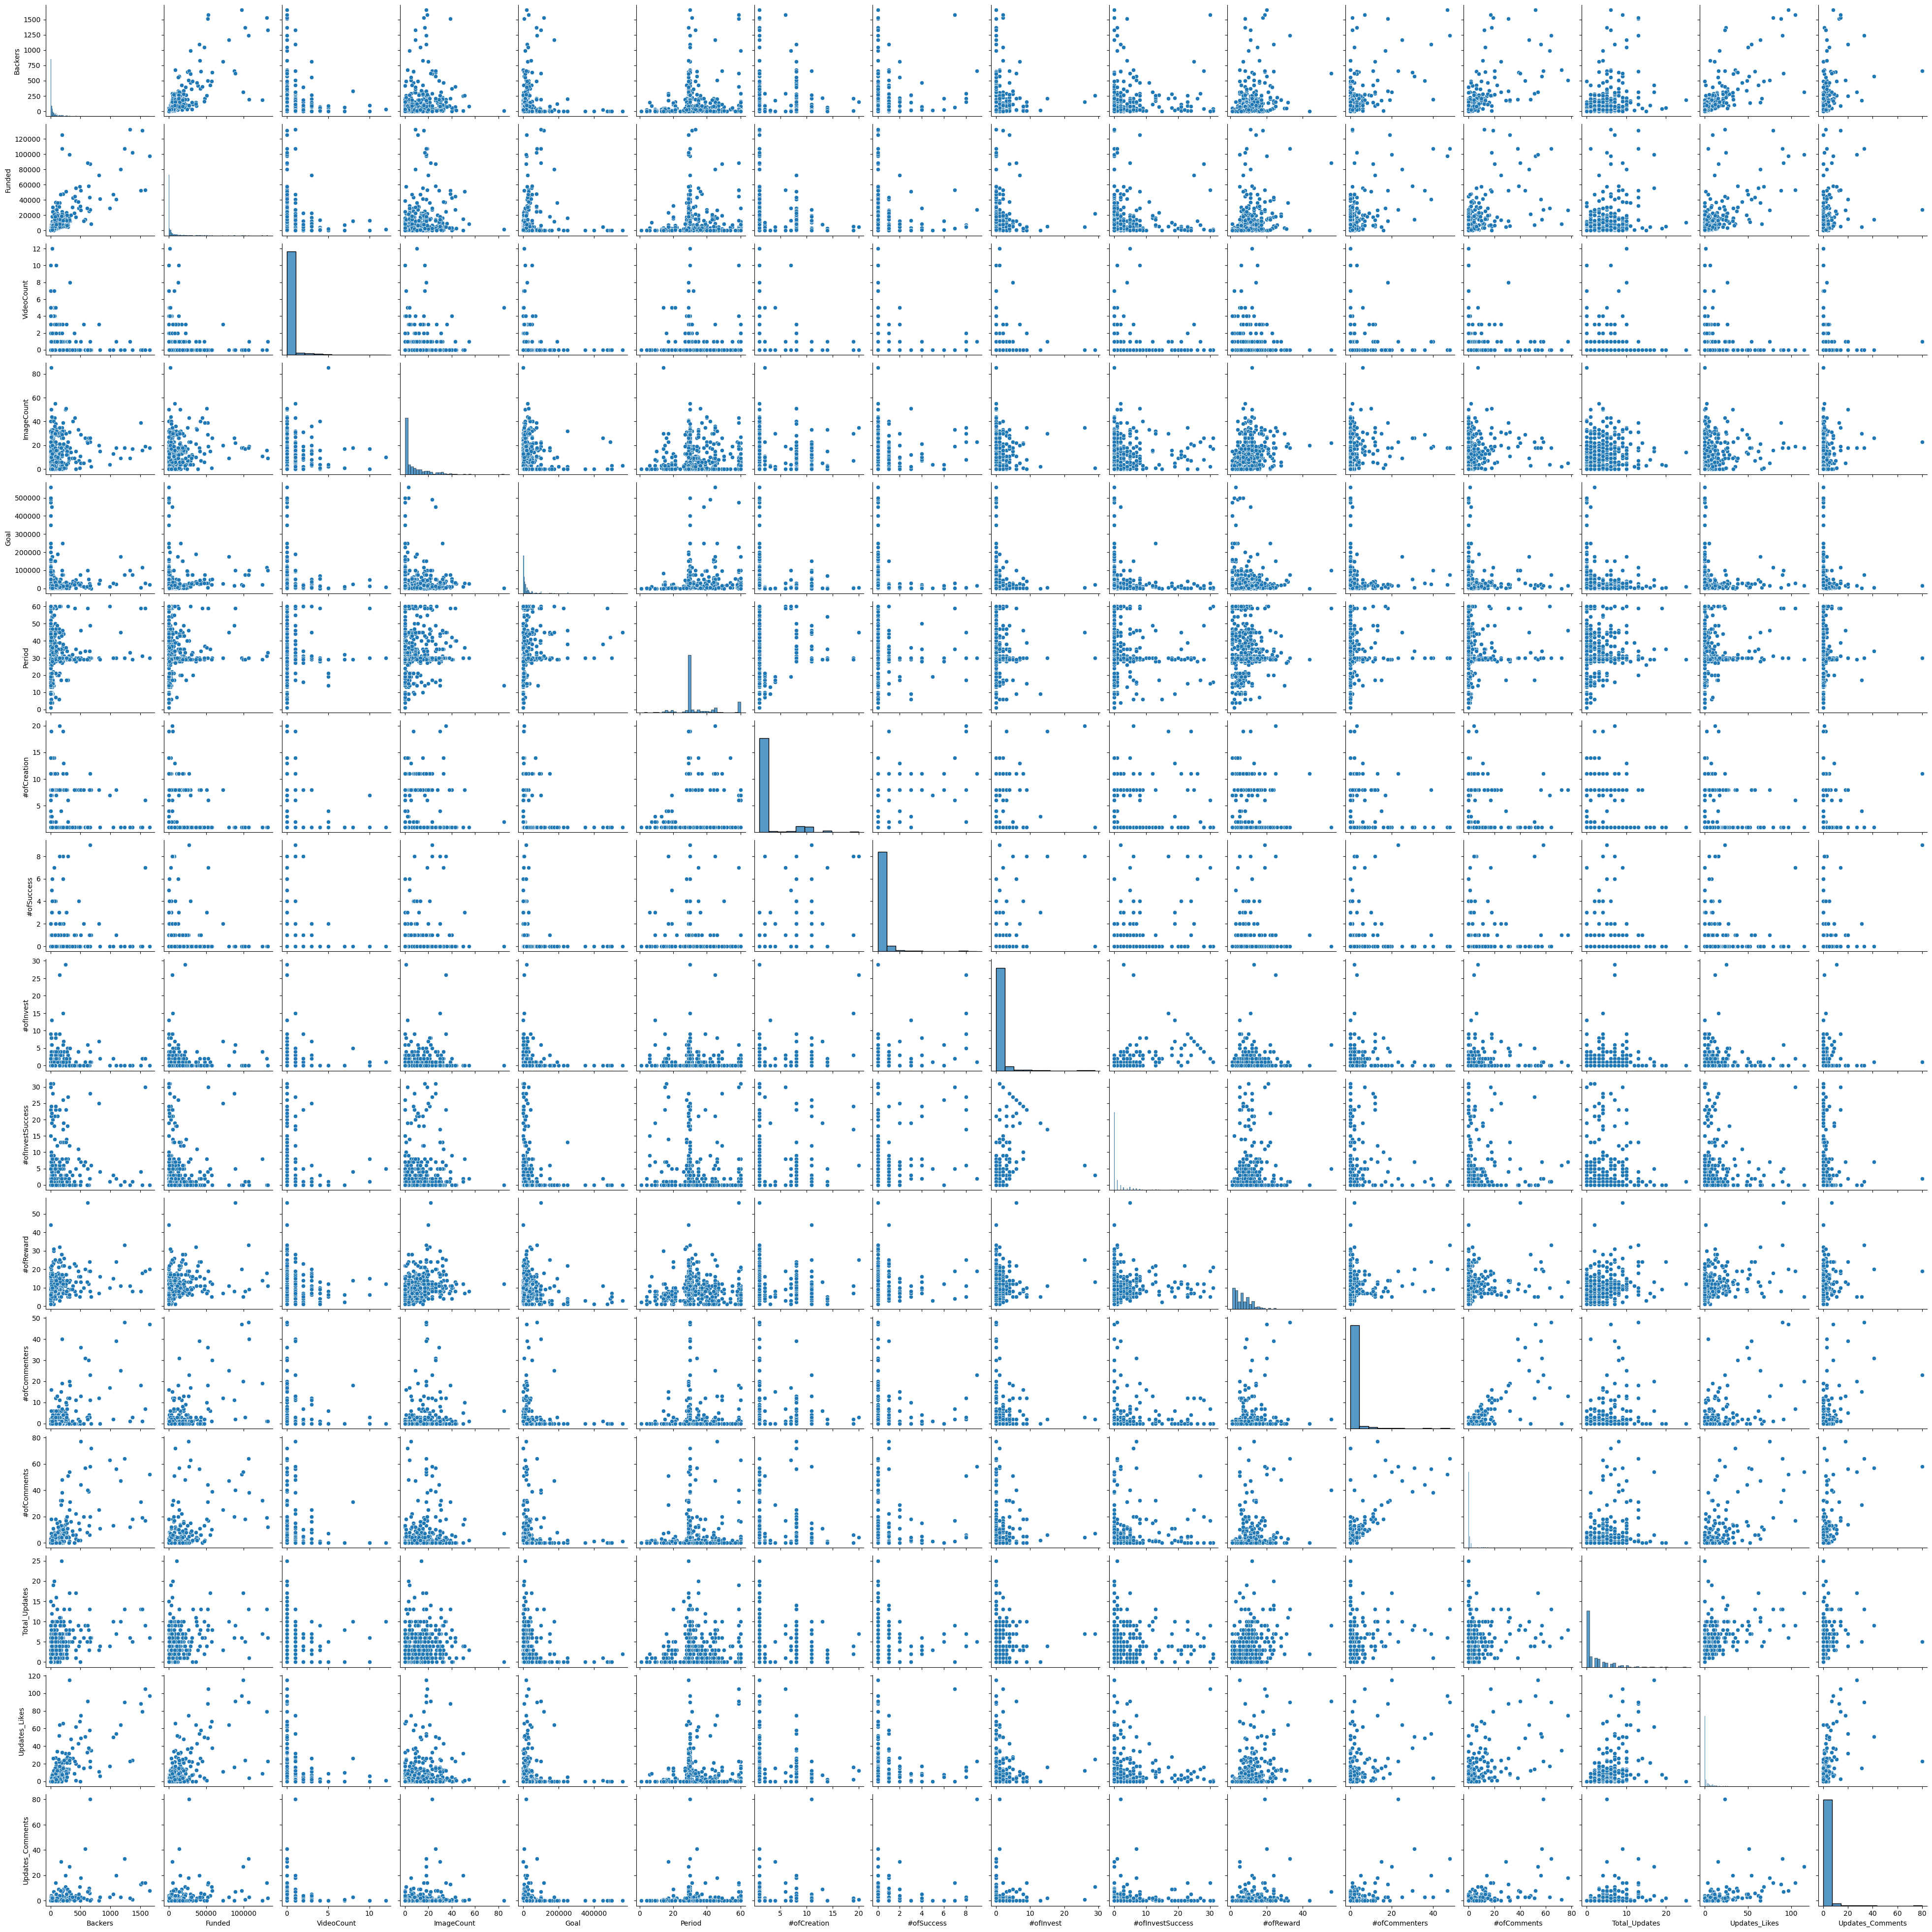

In [ ]:
sns.pairplot(df.drop(columns=['CountryCode', 'TagCode', 'LocationCode']))

Outlier가 사라졌으니 원핫인코딩 시행.

In [138]:
df = pd.get_dummies(df, columns=['CountryCode', 'TagCode', 'LocationCode'])

## Regression

**Q5. 어떤 값을 종속 변수로 둘 것인가?**

'어떤 요인이 *펀딩 금액*에 영향을 미칠까?'
- *X_Variables* -> FundedRate

In [17]:
pd.DataFrame(df.columns)

,0
0,Backers
1,Funded
2,VideoCount
3,ImageCount
4,Goal
5,Period
6,#ofCreation
7,#ofSuccess
8,#ofInvest
9,#ofInvestSuccess


**Q5. 어떤 값을 독립 변수로 둘 것인가?**

<추측>
- Backers: 상식적으로 Backer가 많을수록 Funded가 오른다고 생각할 수 있지만, 한 명이 매우 많은 금액을 펀딩할 수도 있음. 섣부른 판단은 금물.
- VideoCount, ImageCount: 큰 관련이 있어 보이진 않음.
- Goal: 마찬가지로, 펀딩 목표 금액이 높다고 Funded가 오를 것 같진 않음.
- Period: 기간이 길다고 펀딩 금액이 오를 것 같지도 않음.\
...

우선 상관분석을 한 뒤, 지나치게 상관계수가 낮은 column을 제외하고 모델을 만들어보자.

In [240]:
df.corr()[df.corr().index == 'Funded'].drop(columns='Funded')

,Backers,VideoCount,ImageCount,Goal,Period,#ofCreation,#ofSuccess,#ofInvest,#ofInvestSuccess,#ofReward,#ofCommenters,#ofComments,Total_Updates,Updates_Likes,Updates_Comments,CountryCode_1,CountryCode_2,CountryCode_3,CountryCode_4,CountryCode_5,CountryCode_6,CountryCode_7,CountryCode_8,CountryCode_9,CountryCode_10,CountryCode_11,CountryCode_12,CountryCode_14,CountryCode_15,TagCode_1,TagCode_2,TagCode_3,TagCode_4,TagCode_5,TagCode_6,TagCode_7,TagCode_8,TagCode_9,TagCode_10,TagCode_11,TagCode_12,TagCode_13,TagCode_14,TagCode_15,LocationCode_1,LocationCode_2,LocationCode_3,LocationCode_4,LocationCode_5,LocationCode_6,LocationCode_7,LocationCode_8,LocationCode_9,LocationCode_10,LocationCode_11,LocationCode_12,LocationCode_13,LocationCode_14,LocationCode_15
Funded,0.799719,0.039658,0.32322,0.095933,0.014855,0.016195,0.082388,0.122235,0.160311,0.399744,0.590494,0.596602,0.473578,0.69437,0.35523,0.058829,-0.011926,-0.034047,-0.01224,0.008881,-0.028613,-0.031628,-0.046498,-0.022944,0.009725,0.002641,-0.01399,0.108635,-0.026051,-0.02545,-0.016342,-0.017213,-0.001867,0.097588,0.007286,-0.007272,-0.035744,-0.011592,-0.023449,-0.010922,-0.003282,-0.018663,0.009609,0.009383,0.057826,-0.009519,-0.033346,-0.008718,0.006759,-0.028609,-0.028292,-0.046476,-0.023152,0.01191,-0.006004,-0.01399,0.082256,-0.006018,-0.026051


Drop 예정 column
- VideoCount (.03) <- 예상과 일치
- ~~ImageCount (.32)~~
- Goal (.09)   <- 예상과 일치
- Period (.01) <- 예상과 일치
- #ofCreation (.01)
- #ofSuccess (.08)
- #ofInvest (.12)
- #ofInvestSuccess (.16)

In [139]:
df2 = df.drop(columns=['VideoCount', 'Goal', 'Period', '#ofCreation', '#ofSuccess', '#ofInvest', '#ofInvestSuccess'])
RAND_SEED = 42

In [160]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop(columns='Funded'), df2.Funded, random_state=RAND_SEED)

scaler = RobustScaler()
X_train_scaled = np.concatenate([scaler.fit_transform(X_train.iloc[:, :8]), X_train.iloc[:, 8:]], axis=1)
X_test_scaled = np.concatenate([scaler.transform(X_test.iloc[:, :8]), X_test.iloc[:, 8:]], axis=1)

lr = LinearRegression().fit(X_train_scaled, y_train)
print(lr.score(X_train_scaled, y_train))
print(lr.score(X_test_scaled, y_test))

0.70254058734601
0.6592309802438576


In [157]:
df3 = df.drop(columns=['VideoCount', 'Goal', 'Period', '#ofCreation', '#ofSuccess'])

In [163]:
X_train, X_test, y_train, y_test = train_test_split(df3.drop(columns='Funded'), df3.Funded, random_state=RAND_SEED)

scaler = RobustScaler()
X_train_scaled = np.concatenate([scaler.fit_transform(X_train.iloc[:, :11]), X_train.iloc[:, 11:]], axis=1)
X_test_scaled = np.concatenate([scaler.transform(X_test.iloc[:, :11]), X_test.iloc[:, 11:]], axis=1)

lr = LinearRegression().fit(X_train_scaled, y_train)
print(lr.score(X_train_scaled, y_train))
print(lr.score(X_test_scaled, y_test))

0.7027488602073747
0.6542662653897584


df2와 df3간 유의미한 차이가 없으므로 df2를 사용한다.\
 (처음에 제거했던 column을 제거한 상태로 유지)

Ridge와 Lasso를 이용하여 다시 모델을 만들어보자.

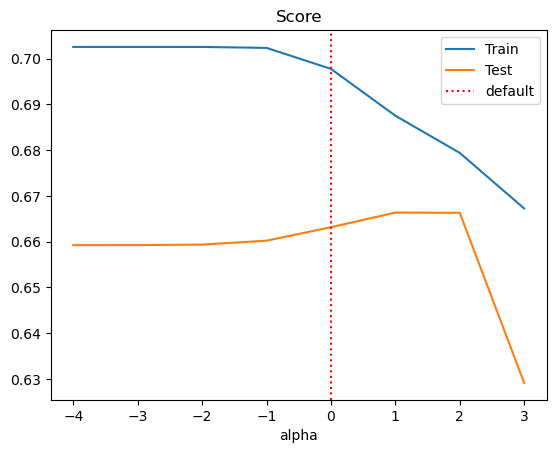

In [164]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop(columns='Funded'), df2.Funded, random_state=RAND_SEED)

scaler = RobustScaler()
X_train_scaled = np.concatenate([scaler.fit_transform(X_train.iloc[:, :8]), X_train.iloc[:, 8:]], axis=1)
X_test_scaled = np.concatenate([scaler.transform(X_test.iloc[:, :8]), X_test.iloc[:, 8:]], axis=1)

train_score, test_score = [], []
alphas = [10 ** i for i in range(-4, 4)]
for a in alphas:
    ridge = Ridge(alpha=a).fit(X_train_scaled, y_train)
    train_score.append(ridge.score(X_train_scaled, y_train))
    test_score.append(ridge.score(X_test_scaled, y_test))
plt.plot(np.log10(alphas), train_score, label='Train')
plt.plot(np.log10(alphas), test_score, label='Test')
plt.xlabel('alpha')
plt.axvline(x=0, color='r', linestyle=':', label='default')
plt.legend()
plt.title('Score')
plt.show()

alpha가 10^2 근처일 때 가장 좋은 것으로 결과가 나왔는데, 모든 특성을 사용하여 다시 훈련해보자.

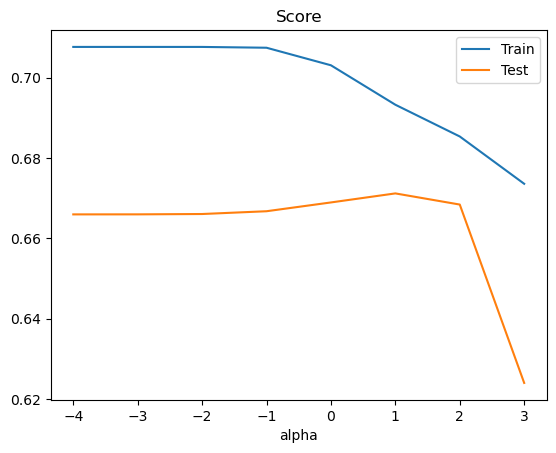

In [165]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Funded'), df.Funded, random_state=RAND_SEED)

scaler = RobustScaler()
X_train_scaled = np.concatenate([scaler.fit_transform(X_train.iloc[:, :16]), X_train.iloc[:, 16:]], axis=1)
X_test_scaled = np.concatenate([scaler.transform(X_test.iloc[:, :16]), X_test.iloc[:, 16:]], axis=1)

train_score, test_score = [], []
for a in alphas:
    ridge = Ridge(alpha=a).fit(X_train_scaled, y_train)
    train_score.append(ridge.score(X_train_scaled, y_train))
    test_score.append(ridge.score(X_test_scaled, y_test))
plt.plot(np.log10(alphas), train_score, label='Train')
plt.plot(np.log10(alphas), test_score, label='Test')
plt.xlabel('alpha')
plt.legend()
plt.title('Score')
plt.show()

큰 차이가 없으나, (일부 특성을 제거한 후) 나머지 특성을 모두 사용하였을 경우에는\
$α = 10$일 때 가장 성능이 좋았다.

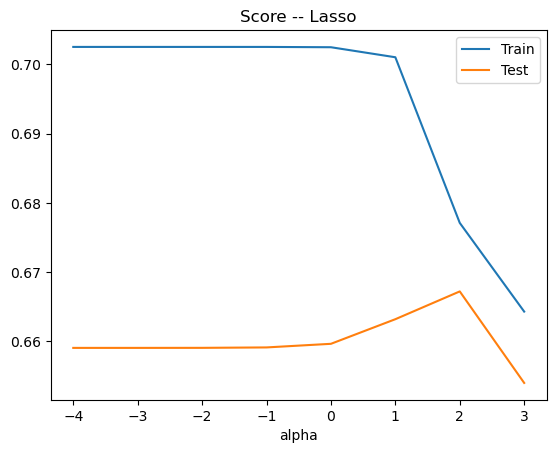

In [166]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop(columns='Funded'), df.Funded, random_state=RAND_SEED)

scaler = RobustScaler()
X_train_scaled = np.concatenate([scaler.fit_transform(X_train.iloc[:, :8]), X_train.iloc[:, 8:]], axis=1)
X_test_scaled = np.concatenate([scaler.transform(X_test.iloc[:, :8]), X_test.iloc[:, 8:]], axis=1)

train_score, test_score = [], []
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000000).fit(X_train_scaled, y_train)
    train_score.append(lasso.score(X_train_scaled, y_train))
    test_score.append(lasso.score(X_test_scaled, y_test))
plt.plot(np.log10(alphas), train_score, label='Train')
plt.plot(np.log10(alphas), test_score, label='Test')
plt.xlabel('alpha')
plt.legend()
plt.title('Score -- Lasso')
plt.show()

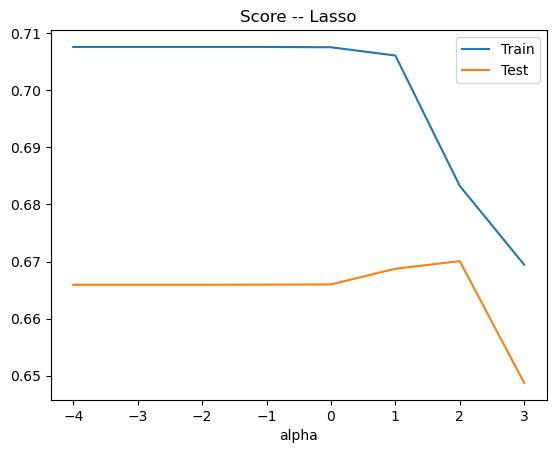

In [167]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Funded'), df.Funded, random_state=RAND_SEED)

scaler = RobustScaler()
X_train_scaled = np.concatenate([scaler.fit_transform(X_train.iloc[:, :16]), X_train.iloc[:, 16:]], axis=1)
X_test_scaled = np.concatenate([scaler.transform(X_test.iloc[:, :16]), X_test.iloc[:, 16:]], axis=1)

train_score, test_score = [], []
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000000).fit(X_train_scaled, y_train)
    train_score.append(lasso.score(X_train_scaled, y_train))
    test_score.append(lasso.score(X_test_scaled, y_test))
plt.plot(np.log10(alphas), train_score, label='Train')
plt.plot(np.log10(alphas), test_score, label='Test')
plt.xlabel('alpha')
plt.legend()
plt.title('Score -- Lasso')
plt.show()

마찬가지로, Lasso에서도 alpha=10^2일 때 가장 적절한 모델이 훈련된다.

## Conclusion

불필요하거나 방해되는 Column을 제거하고, 이상치 값도 찾아서 제거함.\
또한 일반 LR 모델에 비해 Ridge/Lasso에서 $α=10^2$ 파라미터를 적용했을 때\
가장 성능이 좋은 모델이 훈련됨.

처음에는 test score이 음수값(-12)을 가지는 문제가 있었으나, 이상치 값들을 적절히 제거한 후 안정적으로 돌아옴.

In [170]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop(columns='Funded'), df.Funded, random_state=RAND_SEED)

scaler = RobustScaler()
X_train_scaled = np.concatenate([scaler.fit_transform(X_train.iloc[:, :8]), X_train.iloc[:, 8:]], axis=1)
X_test_scaled = np.concatenate([scaler.transform(X_test.iloc[:, :8]), X_test.iloc[:, 8:]], axis=1)

ridge = Ridge(alpha=100).fit(X_train_scaled, y_train)
print(ridge.score(X_train_scaled, y_train))
print(ridge.score(X_test_scaled, y_test))
print()

df_beta = pd.DataFrame(
    np.column_stack((np.array(df2.drop(columns='Funded').columns), np.array(ridge.coef_))),
    columns=['Feature', 'β']
)

df_codes = df_beta[df_beta['Feature'].str.contains('Code_')]
df_beta = df_beta[df_beta['Feature'].str.contains('Code_') == False]
df_beta.sort_values('β', ascending=False, inplace=True)
display(df_beta.style.set_caption('β of features'))

df_country = df_codes[:14]
df_tag = df_codes[14:29]
df_location = df_codes[29:]

display(df_country)
display(df_tag)
display(df_location)

0.6793823901055656
0.6662985347323299



,Feature,β
0,Backers,1601.443958
2,#ofReward,1122.794559
3,#ofCommenters,917.508071
6,Updates_Likes,734.998431
5,Total_Updates,540.181860
1,ImageCount,219.104919
4,#ofComments,-65.301599
7,Updates_Comments,-493.702586


,Feature,β
8,CountryCode_1,646.767402
9,CountryCode_2,168.319129
10,CountryCode_3,-403.803455
11,CountryCode_4,-19.122139
12,CountryCode_5,-236.160594
13,CountryCode_6,-4.156957
14,CountryCode_7,-4.420033
15,CountryCode_8,-121.643491
16,CountryCode_9,-108.717799
17,CountryCode_10,391.359683


,Feature,β
22,TagCode_1,-157.797138
23,TagCode_2,-375.032831
24,TagCode_3,-243.810316
25,TagCode_4,10.835576
26,TagCode_5,-477.239935
27,TagCode_6,572.974834
28,TagCode_7,339.124
29,TagCode_8,-13.751558
30,TagCode_9,-126.667825
31,TagCode_10,-23.613789


,Feature,β
37,LocationCode_1,335.176204
38,LocationCode_2,185.840926
39,LocationCode_3,91.598484
40,LocationCode_4,-9.156633
41,LocationCode_5,-282.648594
42,LocationCode_6,-7.987534
43,LocationCode_7,-2.013681
44,LocationCode_8,-17.238263
45,LocationCode_9,-115.504018
46,LocationCode_10,403.154915


***

- Backer가 많을수록 Funded 금액이 올라감.
- 보상수, 댓글 단 사람 수, 좋아요 수가 많을 수록 펀딩 금액이 올라감.
- Country의 경우, 미국(1)인 경우 펀딩 금액이 올라감.
- Tag의 경우, 의류/웨어러블(6)인 경우 펀딩 금액이 올라감.
  - *Design, Gadget의 경우 가장 펀딩을 기피함.*

이 외에 펀딩을 시작한 사람이 할 수 있는 조치로는
- **이미지를 많이 게시할수록 펀딩 금액이 올라감**
- Total_Updates(수정?)가 많을수록 펀딩 금액이 올라감